# Exploratory Data Analysis

## Background

Load the NYC AirBnB Truncated Dataset. This dataset is a mirror of the full NYC AirBnB dataset found at Kaggle, but only contains the first 10,000 entries. 

https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

For the numerical features, 

1) Display histograms for the numerical features. 

2) Construct the scatter plots of price with each of the numerical features.

3) Display the correlation histogram.  

4) Which numerical feature appears to be most predictive of the price?

5) Using numerical features to predict the renting price with linear model. Write down the predict function.

6) Calculate the RSS cost.

## Set-Up

In [1]:
using DrWatson
@quickactivate "CategoricalDataScience"

In [2]:
using CairoMakie
using CSV
using DataFrames
using Downloads
using MLJ
using MLJLinearModels
using Statistics

In [15]:
df = CSV.read(datadir("exp_raw", "learning", "train.csv"), DataFrame)
df = df[completecases(df), :]

df = df[!, (<:).(eltype.(eachcol(df)), Union{Number,Missing})] |> 
x -> x[!, Not(:host_id, :latitude, :longitude)]

Row,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
,Int64,Int64,Int64,Float64?,Int64,Int64
1,149,1,9,0.21,6,365
2,225,1,45,0.38,2,355
3,89,1,270,4.64,1,194
4,80,10,9,0.1,1,0
5,200,3,74,0.59,1,129
6,60,45,49,0.4,1,0
7,79,2,430,3.47,1,220
8,79,2,118,0.99,1,0
9,150,1,160,1.33,4,188


### Problem 1

**Display histograms for the numerical features.**

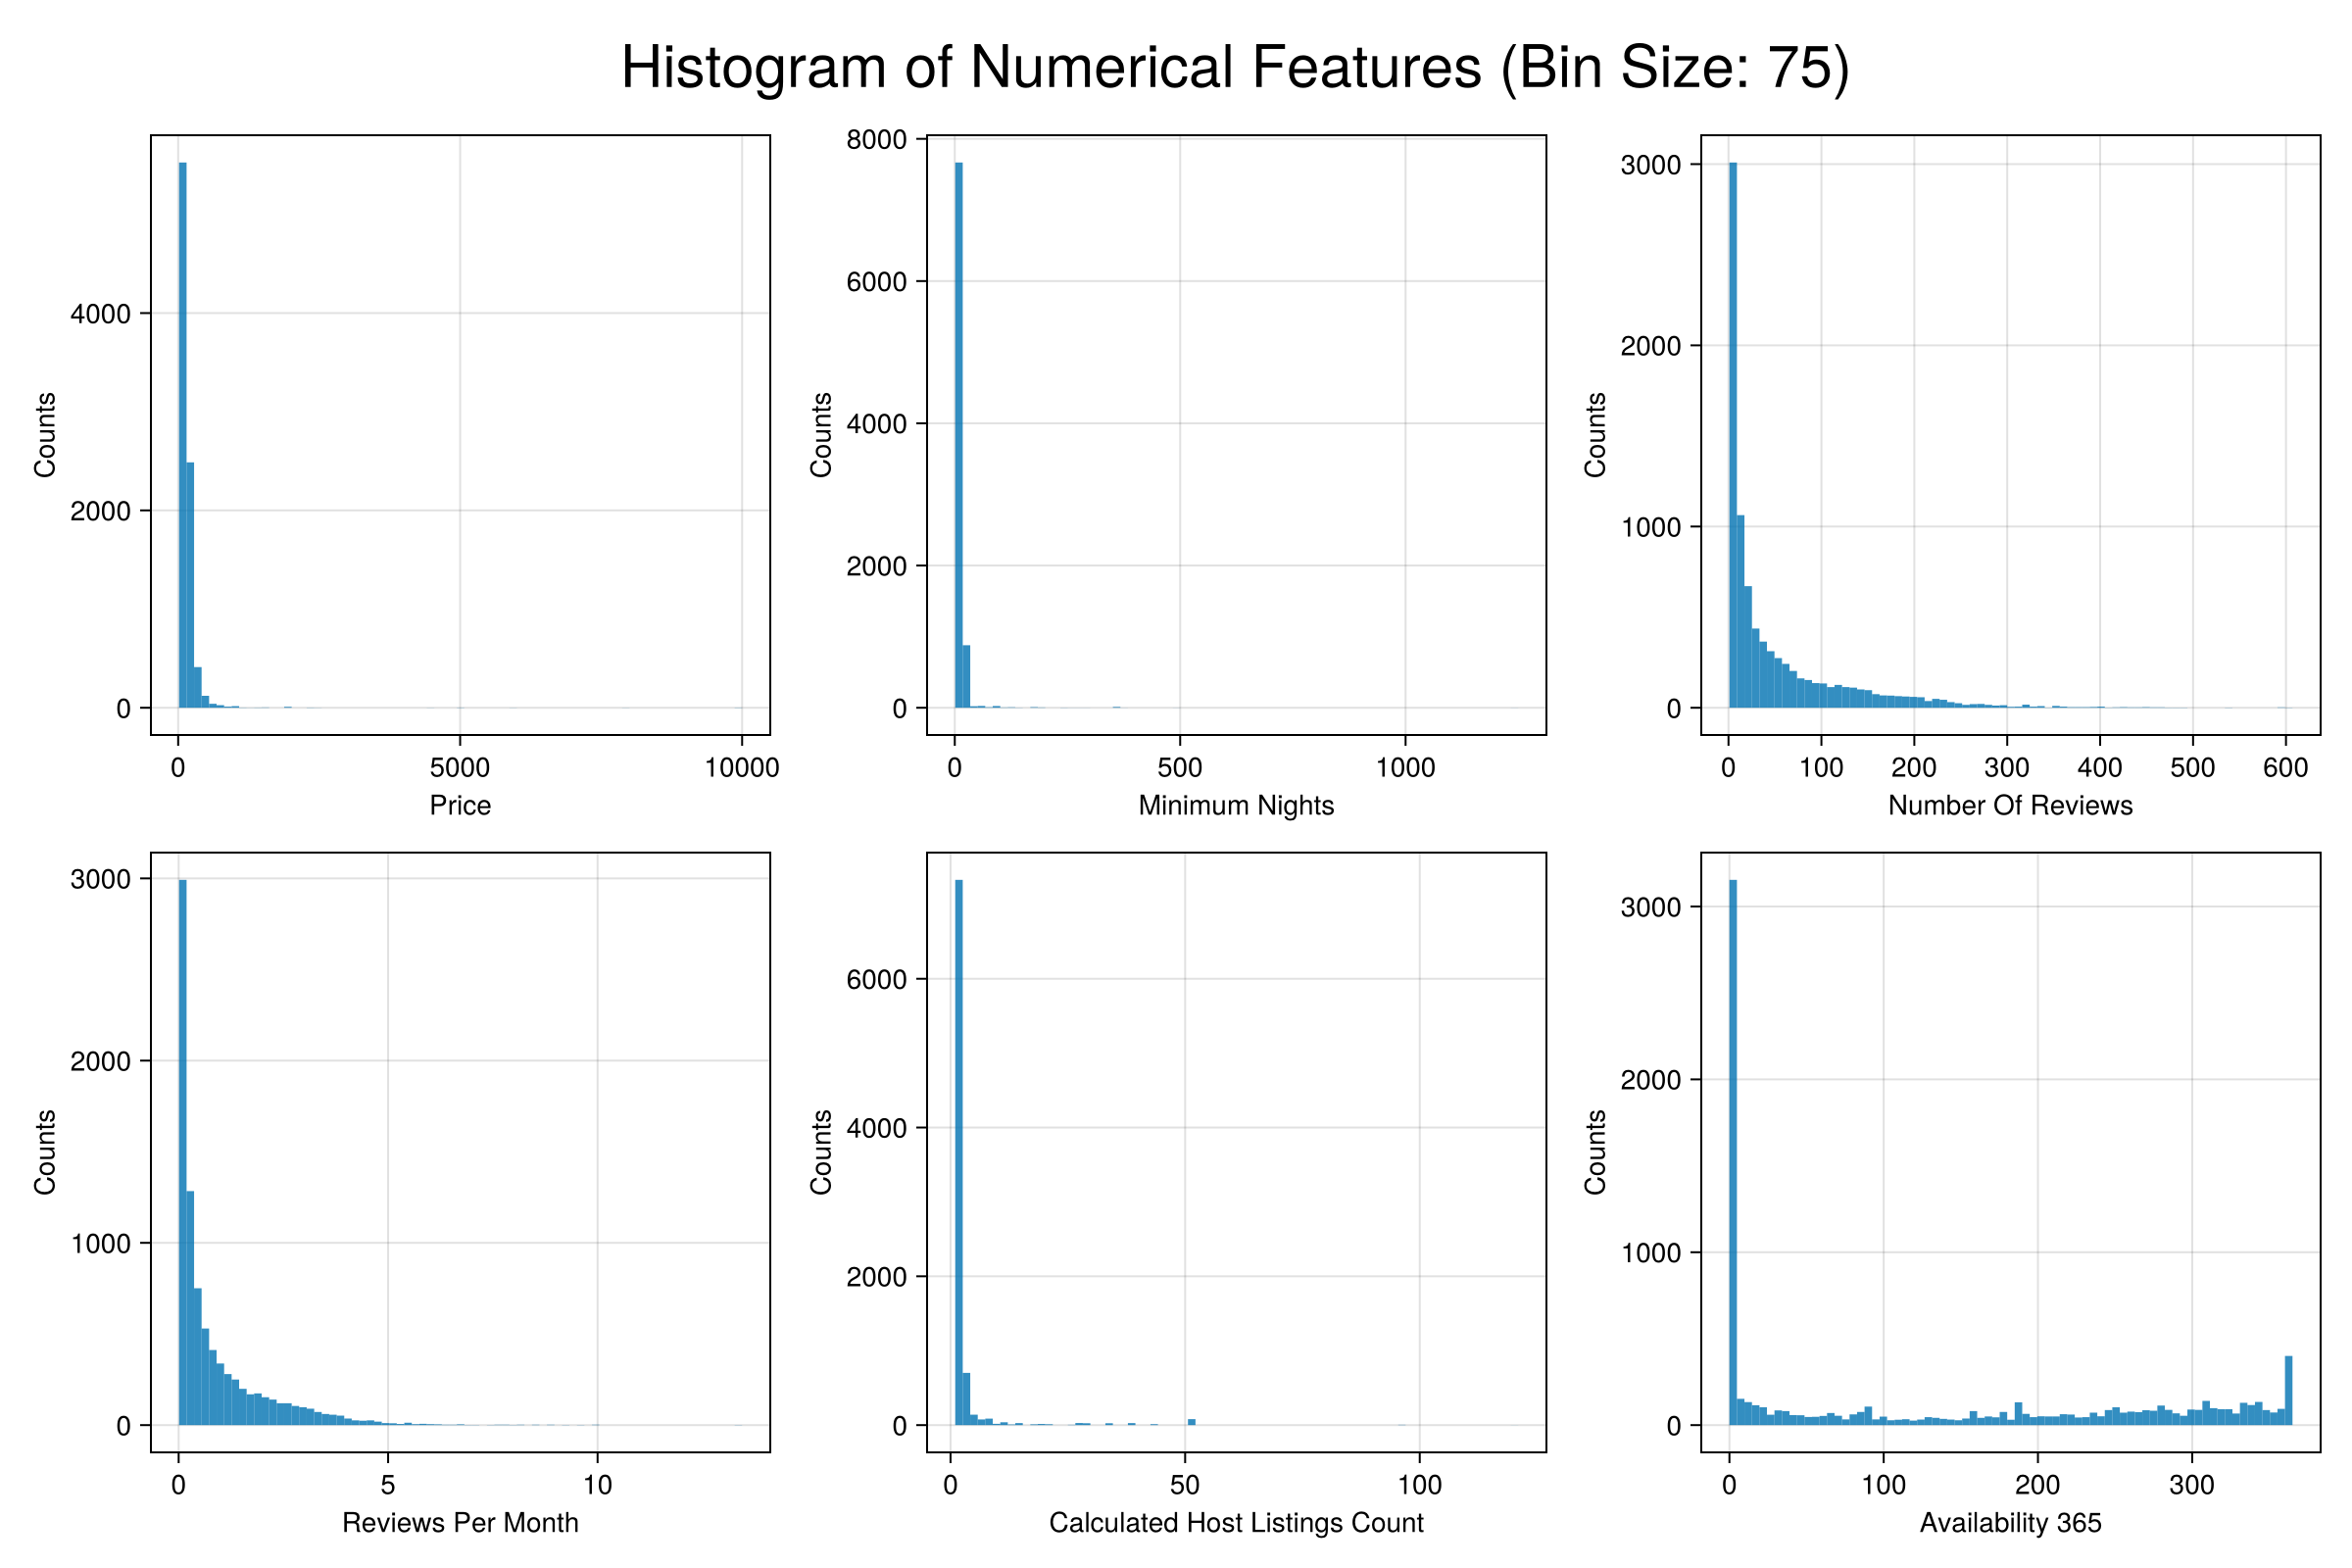

In [4]:
fig = Figure(; size = (1200, 800));

counter = 1
labels = names(df)
for i in 1:2
    for j in 1:3
      ax = Axis(fig[i, j])
      hist!(ax, df[!, counter]; bins = 75)
      ax.xlabel = replace(labels[counter], "_" => " ") |> titlecase
      ax.ylabel = "Counts"
      counter += 1
    end
end

supertitle = Label(fig[0, :], "Histogram of Numerical Features (Bin Size: 75)", fontsize = 30)

fig

### Problem 2

**Construct the scatter plots of price with each of the numerical features.**

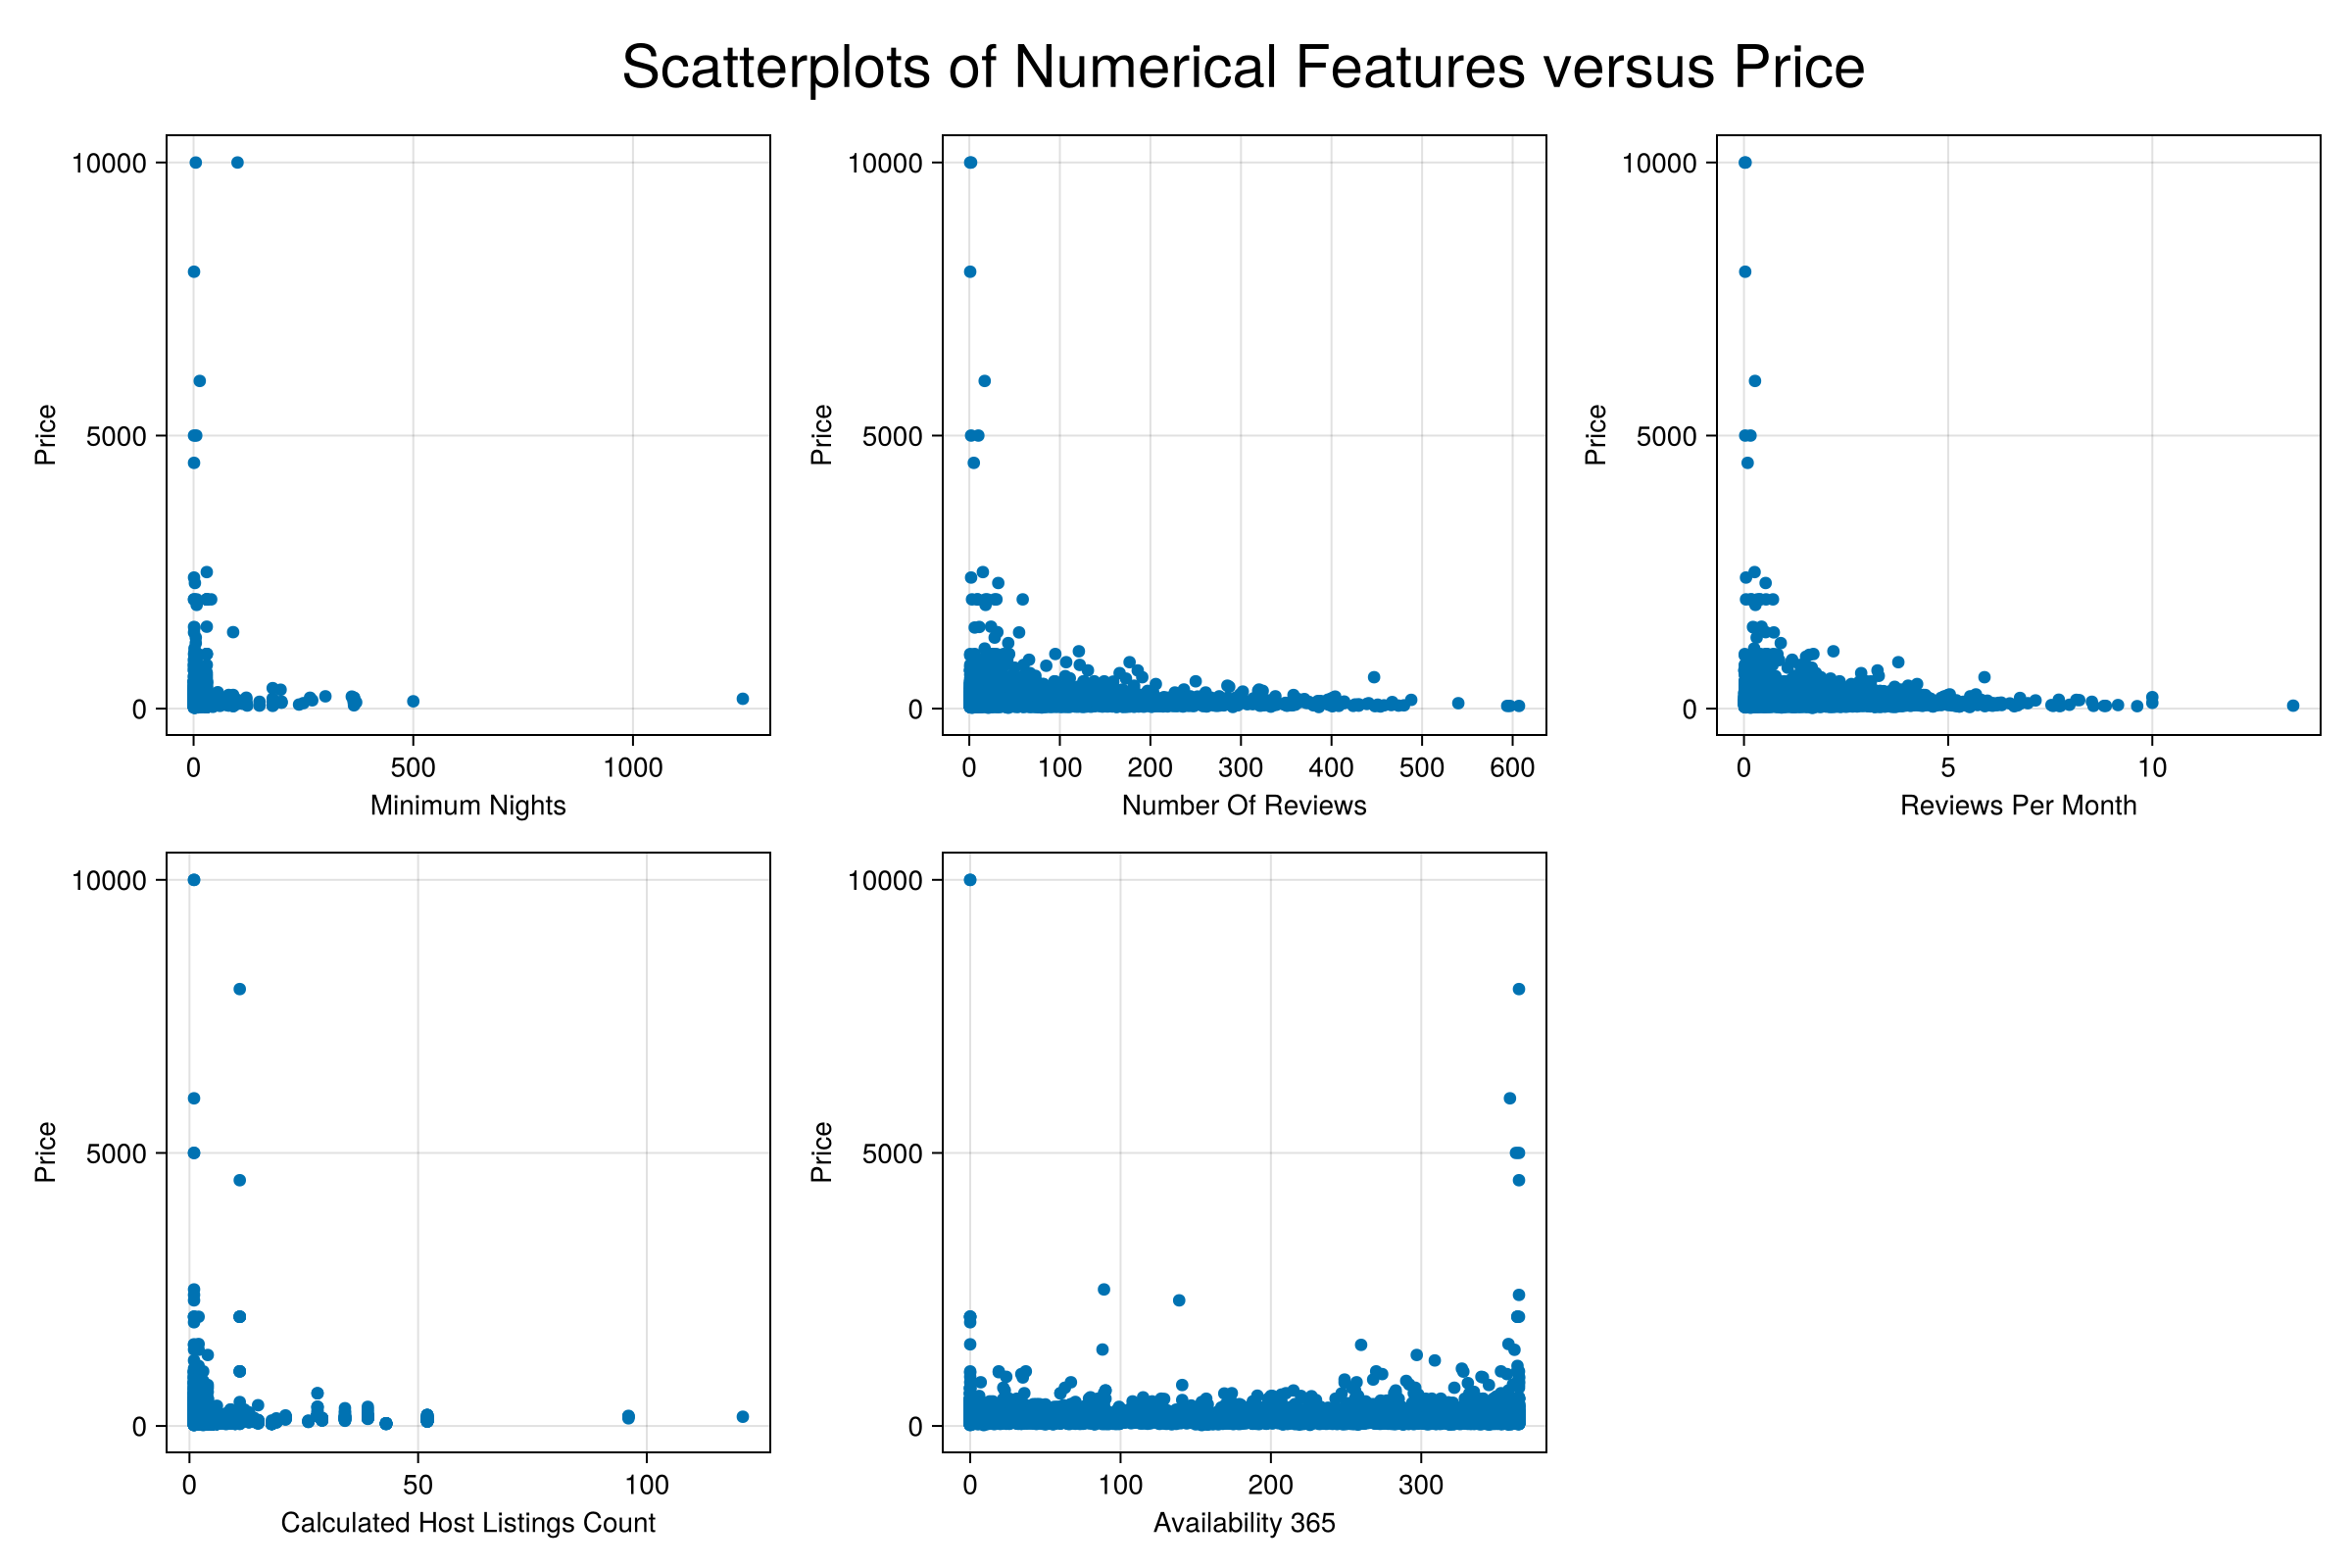

In [5]:
fig = Figure(; size = (1200, 800));

labels = filter(n -> n != "price", names(df))
row_counter = 1
column_counter = 1
for label in labels 
    ax = Axis(fig[row_counter, column_counter])
    scatter!(ax, df[:, label], df.price)
    ax.xlabel = replace(label, "_" => " ") |> titlecase
    ax.ylabel = "Price" 
    if column_counter < 3
      column_counter += 1
    else
      row_counter += 1
      column_counter = 1
    end
end

supertitle = Label(fig[0, :], "Scatterplots of Numerical Features versus Price", fontsize = 30)

fig

### Problem 3

**Display the correlation histogram.**

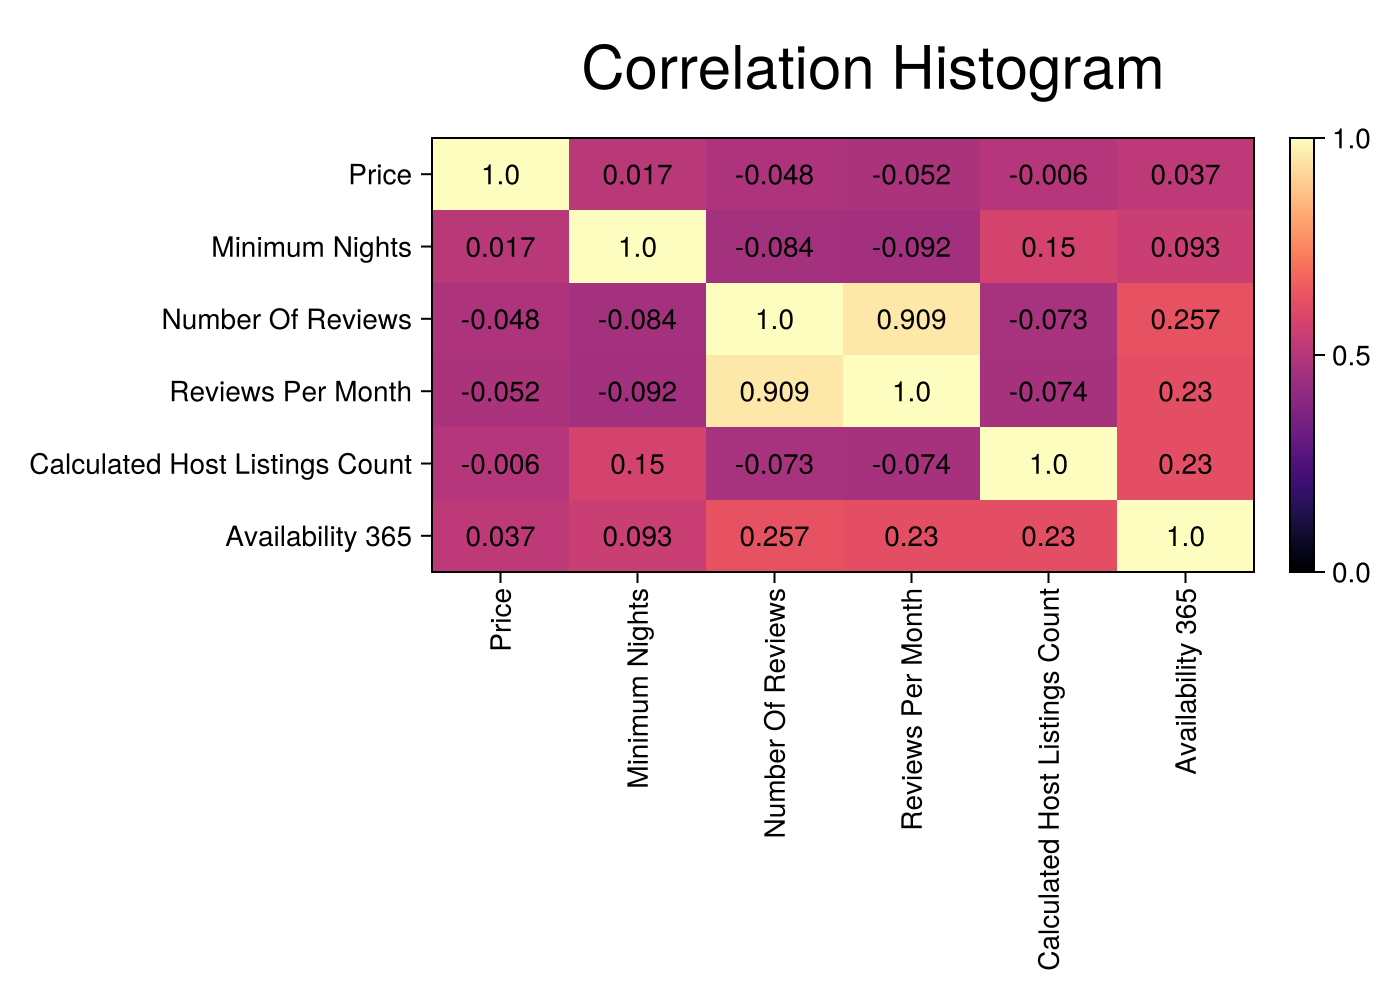

In [6]:
M = cor(Matrix(df))
(n,m) = size(M)

labels = replace.(names(df), "_" => " ") .|> titlecase
fig = Figure(; size = (700, 500));

ax = Axis(fig[1, 1])
Makie.heatmap!(ax, M; colormap = :magma, colorrange = (-1,1))

ax.xticks = (1:m, labels)
ax.yticks = (1:m, labels)
ax.yreversed = true
ax.xticklabelrotation = π/2

Makie.Colorbar(fig[1, 2], colormap = :magma);

for i in 1:n
  for j in 1:m
    Makie.text!(ax,
                "$(round(M[i,j],digits=3))",
                position = (i,j),
                align = (:center, :center), 
                fontsize=14,
                color = :black)
  end
end

supertitle = Label(fig[0, :], "Correlation Histogram", fontsize = 30)

fig

**Bonus: Show the correlation matrix**

In [7]:
M

6×6 Matrix{Float64}:
  1.0          0.0174106  -0.0481667  -0.0519647  -0.00557913  0.036689
  0.0174106    1.0        -0.084284   -0.0920755   0.149947    0.0928448
 -0.0481667   -0.084284    1.0         0.90899    -0.0730831   0.257172
 -0.0519647   -0.0920755   0.90899     1.0        -0.0742808   0.229506
 -0.00557913   0.149947   -0.0730831  -0.0742808   1.0         0.230261
  0.036689     0.0928448   0.257172    0.229506    0.230261    1.0

### Problem 4

**Which numerical feature appears to be most predictive of the price?**

Based on the correlation plot, it would appear that the **Price** is correlated with **Availability 365** with the highest correlation being $\approx 0.037$.

### Problem 5

**Using numerical features, predict the renting price using a linear model. Write down the prediction function.**

<!--TODO: Clean up histogram-->

In [8]:
@load LinearRegressor pkg=MLJLinearModels verbosity=0

df.reviews_per_month = float.(df.reviews_per_month)
X = df[:, Not(:price)]
y = df[:, :price]
mach = fit!(machine(LinearRegressor(), X, y; scitype_check_level=0));

[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: Analytical
│   iterative: Bool false
└   max_inner: Int64 200


Here is the general prediction function:

$h_{\theta}(x) = \theta_1 + \theta_2 x_2 + \theta_3 x_3 + \theta_4 x_4 + \theta_5 x_5 + \theta_6 x_6$

and this is the computed prediction function with its intercept (rounded to $5$ significant digits):

$h_{\theta}(x) = 153.65 + 0.09719 x_2 + -0.07571 x_3 + -9.63866 x_4 + -0.90427 x_5 + 0.10260 x_6$

In [9]:
fitted_params(mach).coefs

5-element Vector{Pair{Symbol, Float64}}:
                 :minimum_nights => 0.09718591955220802
              :number_of_reviews => -0.07571175774498533
              :reviews_per_month => -9.638658287035668
 :calculated_host_listings_count => -0.9042657259325844
               :availability_365 => 0.10260201438121613

In [10]:
fitted_params(mach).intercept

153.65304935840274

In [11]:
X = hcat(ones(length(y)), Matrix(X));

In [12]:
h(X, θ) = θ[1]*X[:, 1] .+ θ[2]*X[:, 2] .+ θ[3]*X[:, 3] .+ θ[4]*X[:, 4] .+ θ[5]*X[:, 5] .+ θ[6]*X[:, 6];

In [13]:
θ = (X' * X)^-1 * X' * y;

### Problem 6

**Calculate the RSS cost.**

Using the RSS cost function:

$\sum_{i = 1}^{n}(h_{\theta}(\vec{x}^{(i)}) - y^{(i)})^2$

Using the computation from earlier, we get: 

In [14]:
sum((predict(mach, X[:, 2:end]) .- y).^2)

5.049697970319e8